# Importing libraries

In [0]:
import math
import numpy as np

from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.preprocessing import PolynomialFeatures

# Generating Data

* Generate inputs  
$\{x^{(i)}_1, x^{(i)}_2, x^{(i)}_3 | i = 1, ..., 10000\}$,  
$(x_j \in [-3, 3),\ j = 1, 2, 3)$

* Generate outputs  
$y^{(i)} = 2.0 + 1.0 (x^{(i)}_1) + 0.5 (x^{(i)}_1)^2 + 0.25 (x^{(i)}_1)^3 + 0.5 (x^{(i)}_2)^2 + \mbox{noise}$,  
$(\mbox{noise} \sim N(0, 1),\ i = 1, ..., 10000)$

In [3]:
# We will generate 10000 data
m = 10000

# X \in (-3, 3)
X1 = 6 * np.random.rand(m, 1) - 3
X2 = 6 * np.random.rand(m, 1) - 3
X3 = 6 * np.random.rand(m, 1) - 3

X1_1dim = X1.reshape(-1)
X2_1dim = X2.reshape(-1)
X3_1dim = X3.reshape(-1)

# Combine each data points to transfrom data structure
# (X1_1, X1_2, …), (X2_1, X2_2, …), (X3_1, X3_2, ...)
# → (X1_1, X2_1, X3_1), (X1_2, X2_2, X3_2), ...

X = np.c_[X1_1dim, X2_1dim, X3_1dim]

# Generating Y data
noise = np.random.normal(0.0, 1.0, size=(m,))

Y = 2.0 + \
    1.0 * X1_1dim + \
    0.5 * X1_1dim ** 2 + \
    0.25 * X1_1dim ** 3 + \
    0.5 * X2_1dim ** 2 + \
    noise

dataset = np.c_[X, Y]

print(dataset[:5])

[[ 0.73278726 -2.17905117 -1.83639982  5.73526064]
 [ 1.85797871  2.90755686  2.43921771 13.79948726]
 [-1.6926183   2.14041071  2.89650188  2.69593317]
 [-1.86862936  2.80170434 -1.61530337  4.2044786 ]
 [ 0.83834209  2.16530846 -1.70133651  5.17662523]]


## Ploting generated data

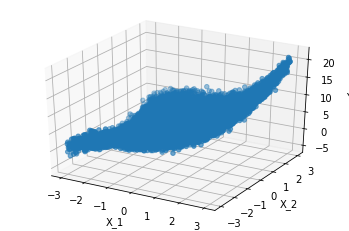

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel('X_1')
ax.set_ylabel('X_2')
ax.set_zlabel('Y')

ax.scatter(X1_1dim, X2_1dim, Y)
plt.show()

## Splitting Data (Prob1)

* Split 10000 data into  
    * 8000 training set,  
    * 1000 validation set,  
    * 1000 test set

In [5]:
train_set = dataset[:8000]
validation_set = dataset[8000:9000]
test_set = dataset[9000:]

print(train_set.shape, validation_set.shape, test_set.shape)

(8000, 4) (1000, 4) (1000, 4)


# Before Training

## Helper functions

* split_dataset  
Gets dataset for input, Returns X, Y  
$X = [1\ x_1\ x_2\ x_3]$

* pretty_print  
Prints loss and parameters pretty

In [0]:
features = PolynomialFeatures(degree = 5)

def split_dataset(dataset, features=features):
    *x, y = dataset.T
    return features.fit_transform(np.stack(tuple(x), axis=-1)), y

split_dataset(train_set)
x_names = features.get_feature_names(['X1', 'X2', 'X3'])

def pretty_print(method_name, theta, dataset=test_set):
    column_width = 30
    header_size = (column_width - len(method_name) - 2) / 2

    print(
        "=" * int(math.floor(header_size)) +
        " %s " % method_name +
        "=" * int(math.ceil(header_size))
    )

    print("Loss       : %6.4f" % rmse_loss_evaluate(theta, dataset))
    
    print("Parameters :")
    max_poly_len = max([len(poly) for poly in x_names])
    x_list_poly_pad = [
        poly + " " * (max_poly_len - len(poly)) for poly in x_names
    ]

    theta_len = len(theta)
    for i in range(0, theta_len, 5):
        print(
            " " * 13 +
            " | ".join([
                "%s %+.4f" % (x_list_poly_pad[i + j], theta[i + j])
                    if i + j < theta_len else " " * (max_poly_len  + 8)
                for j in range(5)
            ])
        )


## Defining RMSE loss function

$$RMSE = \sqrt{\frac{1}{n} \sum^n_{i = 1} (Y_i - \hat{Y_i})^2}$$

* rmse_loss  
Calculate RMSE for given $y$ and $\hat{y}$

* rmse_loss_evaluate  
Get RMSE for given parameter theta and dataset.

In [0]:
def rmse_loss(y, y_hat):
    mse = np.mean((y - y_hat) ** 2)
    rmse = np.sqrt(mse)

    return rmse

def rmse_loss_evaluate(theta, dataset, features=features):
    X, Y = split_dataset(dataset, features)
    return rmse_loss(Y, np.dot(X, theta).squeeze())
    

## Helper functions for Minibatch
* minibatch  
Runs Minibatch Gradient Descent for given gradient gradient_fn.  
Returns theta, which is the optimized parameter, and logs.

* minibatch_plot  
Plot the learning curve using logs, which are output of minibatch function.

In [0]:
def minibatch(
    gradient_fn, batch_size=100, epochs=200, lr=0.000005,
    train_set=train_set, validation_set=validation_set, features=features,
    verbose=True
):
    train_X, train_Y = split_dataset(train_set, features)

    train_num = train_X.shape[0]
    theta = np.random.randn(train_X.shape[1],1)
    data_list = []

    epoch_per_output = int(epochs / 20)

    for epoch in range(epochs):
        # Generating shuffled dataset

        train_set_s = np.random.permutation(train_set)
        train_X_s, train_Y_s = split_dataset(train_set_s, features)

        for i in range(0, train_num, batch_size):
            batch_x = train_X_s[i:i + batch_size]
            batch_y = train_Y_s[i:i + batch_size]

            gradient = gradient_fn(batch_x, batch_y, theta) / len(batch_x)
            theta = theta - lr * gradient
        
        # Calculate Loss
        data = {
            'train': rmse_loss_evaluate(theta, train_set, features),
            'validation': rmse_loss_evaluate(theta, validation_set, features),
            'epoch': epoch
        }

        if verbose and epoch % epoch_per_output == 0:
            print(
                ('Epoch: {epoch:3d}, ' +
                'Train Loss: {train:.4f}, ' +
                'Val Loss: {validation:.4f}').format(**data)
            )
        
        data_list.append(data)
    
    return theta, data_list


def minibatch_plot(data_list):
    train_data = [data['train'] for data in data_list]
    val_data = [data['validation'] for data in data_list]

    plt.plot(train_data, "r+", linewidth=2, label="train")
    plt.plot(val_data, "b-", linewidth=3, label="val")

    plt.xlabel('Epoch')
    plt.ylabel('Loss')


### Testing Minibatch Function

Runs a polynomial regression with minibatch gradient descent to test the minibatch function.  
The dataset is generated like this:

$$x^{(i)} \in [-3, 3)\ (i = 1, ..., 1000)$$  
$$y^{(i)} = 2.0 (x^{(i)}) + 4.0 (x^{(i)})^2$$  


Epoch:   0, Train Loss: 12.6278, Val Loss: 12.8057
Epoch: 2500, Train Loss: 0.9658, Val Loss: 0.9706
Epoch: 5000, Train Loss: 0.6926, Val Loss: 0.6991
Epoch: 7500, Train Loss: 0.6025, Val Loss: 0.6075
Epoch: 10000, Train Loss: 0.5422, Val Loss: 0.5460
Epoch: 12500, Train Loss: 0.4945, Val Loss: 0.4976
Epoch: 15000, Train Loss: 0.4532, Val Loss: 0.4558
Epoch: 17500, Train Loss: 0.4161, Val Loss: 0.4184
Epoch: 20000, Train Loss: 0.3823, Val Loss: 0.3843
Epoch: 22500, Train Loss: 0.3513, Val Loss: 0.3532
Epoch: 25000, Train Loss: 0.3229, Val Loss: 0.3245
Epoch: 27500, Train Loss: 0.2968, Val Loss: 0.2983
Epoch: 30000, Train Loss: 0.2727, Val Loss: 0.2741
Epoch: 32500, Train Loss: 0.2507, Val Loss: 0.2519
Epoch: 35000, Train Loss: 0.2304, Val Loss: 0.2315
Epoch: 37500, Train Loss: 0.2117, Val Loss: 0.2128
Epoch: 40000, Train Loss: 0.1946, Val Loss: 0.1956
Epoch: 42500, Train Loss: 0.1789, Val Loss: 0.1798
Epoch: 45000, Train Loss: 0.1644, Val Loss: 0.1652
Epoch: 47500, Train Loss: 0.1511, 

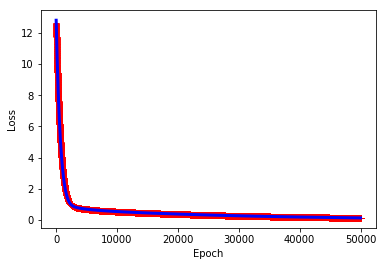

In [9]:
mt_dataset_count = 1000
mt_x1 = 6 * np.random.rand(mt_dataset_count, 1) - 3
mt_x1_1dim = mt_x1.reshape(-1)

mt_x = np.c_[mt_x1_1dim]
mt_y = 2.0 * mt_x1_1dim + 4.0 * mt_x1_1dim ** 2

mt_dataset = np.c_[mt_x, mt_y]
mt_trainset_size = int(mt_dataset_count * .8)
mt_features = PolynomialFeatures(degree = 2)

def gradient_fn(batch_x, batch_y, theta):
    return np.dot(batch_x.T, np.dot(batch_x, theta) - batch_y.reshape((-1, 1)))

mt_param, mt_data = minibatch(
    gradient_fn,
    lr=0.00001,
    epochs=50000,
    batch_size=100,
    train_set=mt_dataset[:mt_trainset_size],
    validation_set=mt_dataset[mt_trainset_size:mt_dataset_count],
    features=mt_features
)

print(mt_param)

# assert mt_data.pop()['validation'] < 0.1

minibatch_plot(mt_data)

## Helper functions for Hyperparameter Tuning
* try_alpha_minibatch  
Runs minibatch for multiple alpha values **naively** and returns alpha of the best result.  
It is deprecated as it is too slow.

* try_alpha_skl  
Same as try_alpha_minibatch but this uses scikit learn to evaluate the loss.

In [0]:
def _skl_alpha_evaluation(
    alpha, alpha_train_set, alpha_validation_set,
    regularization_type='l1', lr=0.01, epochs=10000
):
    atx, aty = split_dataset(alpha_train_set)

    regressor = SGDRegressor(
        loss='squared_loss', penalty=regularization_type,
        alpha=alpha, fit_intercept=False,
        eta0=lr, max_iter=epochs
    )

    regressor.fit(atx, aty)
    loss = rmse_loss_evaluate(
        regressor.coef_, alpha_validation_set
    )

    return loss


def _minibatch_alpha_evaluation(
    alpha, alpha_train_set, alpha_validation_set,
    **kwargs
):
    alpha_gradient_fn = kwargs['alpha_gradient_fn']

    theta, data = minibatch(
        alpha_gradient_fn(alpha),
        verbose=False,
        train_set=alpha_train_set,
        validation_set=alpha_validation_set,
        **kwargs
    )

    return data.pop()['validation']


def try_alpha(
    evaluation_fn,
    max_depth=5, set_iteration=1, iteration=3,
    alpha_start=0, alpha_end=0.1, alpha_step=5,
    **kwargs
):

    for depth in range(max_depth):
        print("Examining Alpha for %.4f, %.4f" % (alpha_start, alpha_end))

        alpha_list = np.linspace(alpha_start, alpha_end, alpha_step)
        step_size = (alpha_end - alpha_start) / alpha_step

        min_score = float('inf')
        min_alpha = 0

        for alpha in alpha_list:
            loss_window = []
            set_chunk = int(len(train_set) / iteration)

            for j in range(set_iteration):
                for i in range(iteration):
                    alpha_train_set = np.r_[
                        train_set[: i * set_chunk],
                        train_set[(i + 1) * set_chunk :]
                    ]
                    
                    alpha_validation_set = \
                        train_set[i * set_chunk : (i + 1) * set_chunk]
                    
                    loss_window.append(evaluation_fn(
                        alpha, alpha_train_set, alpha_validation_set,
                        **kwargs
                    ))
            
            loss_avg = sum(loss_window) / len(loss_window)
            loss_min = min(loss_window)
            score = loss_avg * 0.9 + loss_min * 0.1

            print(
                "Alpha %.4f > Min Loss %.4f, Avg Loss %.4f, Score %.4f" %
                (alpha, loss_min, loss_avg, score)
            )

            if score < min_score:
                min_score = score
                min_alpha = alpha
        
        alpha_start = max(0, min_alpha - step_size / 2)
        alpha_end = min(1, min_alpha + step_size / 2)
        print()

    
    return (alpha_start + alpha_end) / 2


try_alpha_minibatch = lambda **kwargs: try_alpha(
    _minibatch_alpha_evaluation, **kwargs
)

try_alpha_skl = lambda **kwargs: try_alpha(
    _skl_alpha_evaluation, **kwargs
)


## Getting parameters to learn (Prob 2)

In [11]:
train_X, train_Y = split_dataset(train_set)
print("%d parameters to learn :" % len(x_names), x_names)

56 parameters to learn : ['1', 'X1', 'X2', 'X3', 'X1^2', 'X1 X2', 'X1 X3', 'X2^2', 'X2 X3', 'X3^2', 'X1^3', 'X1^2 X2', 'X1^2 X3', 'X1 X2^2', 'X1 X2 X3', 'X1 X3^2', 'X2^3', 'X2^2 X3', 'X2 X3^2', 'X3^3', 'X1^4', 'X1^3 X2', 'X1^3 X3', 'X1^2 X2^2', 'X1^2 X2 X3', 'X1^2 X3^2', 'X1 X2^3', 'X1 X2^2 X3', 'X1 X2 X3^2', 'X1 X3^3', 'X2^4', 'X2^3 X3', 'X2^2 X3^2', 'X2 X3^3', 'X3^4', 'X1^5', 'X1^4 X2', 'X1^4 X3', 'X1^3 X2^2', 'X1^3 X2 X3', 'X1^3 X3^2', 'X1^2 X2^3', 'X1^2 X2^2 X3', 'X1^2 X2 X3^2', 'X1^2 X3^3', 'X1 X2^4', 'X1 X2^3 X3', 'X1 X2^2 X3^2', 'X1 X2 X3^3', 'X1 X3^4', 'X2^5', 'X2^4 X3', 'X2^3 X3^2', 'X2^2 X3^3', 'X2 X3^4', 'X3^5']


# Training


## Regressions &lt;Scikit-Learn&gt; (For comparison)

In [12]:
def train_polynomial_scikit():
    lin_reg = LinearRegression(fit_intercept = False)
    lin_reg.fit(train_X, train_Y)

    return lin_reg.coef_

pretty_print("Polynomial, ScikitLearn", train_polynomial_scikit())


def train_ridge_sgd_scikit():
    sgd_reg = SGDRegressor(
        penalty='l2', learning_rate='constant', eta0=0.000001
    )

    for i in range(200):
        sgd_reg.partial_fit(train_X, train_Y)

    return sgd_reg.coef_

pretty_print("Ridge, SGD, ScikitLearn", train_ridge_sgd_scikit())


== Polynomial, ScikitLearn ===
Loss       : 1.0318
Parameters :
             1            +1.8915 | X1           +1.0704 | X2           -0.0597 | X3           +0.0255 | X1^2         +0.5189
             X1 X2        +0.0001 | X1 X3        -0.0077 | X2^2         +0.5196 | X2 X3        -0.0106 | X3^2         +0.0010
             X1^3         +0.2080 | X1^2 X2      +0.0010 | X1^2 X3      +0.0078 | X1 X2^2      +0.0272 | X1 X2 X3     -0.0058
             X1 X3^2      -0.0302 | X2^3         +0.0185 | X2^2 X3      -0.0101 | X2 X3^2      +0.0025 | X3^3         -0.0108
             X1^4         -0.0009 | X1^3 X2      +0.0004 | X1^3 X3      +0.0002 | X1^2 X2^2    -0.0014 | X1^2 X2 X3   +0.0021
             X1^2 X3^2    +0.0004 | X1 X2^3      -0.0005 | X1 X2^2 X3   +0.0020 | X1 X2 X3^2   -0.0008 | X1 X3^3      -0.0001
             X2^4         -0.0009 | X2^3 X3      -0.0002 | X2^2 X3^2    -0.0009 | X2 X3^3      +0.0021 | X3^4         +0.0006
             X1^5         +0.0042 | X1^4 X2      -0.00

## Polynomial Regression &lt;Normal Equation&gt; (Prob 3)

$$\hat{\theta} = (X^T X)^{-1} X^T y$$

In [13]:
def train_polynomial_normal():
    return np.dot(
        np.dot(
            np.linalg.inv(np.dot(train_X.T, train_X)),
            train_X.T
        ),
        train_Y
    )

pretty_print("Polynomial, Normal", train_polynomial_normal())

===== Polynomial, Normal =====
Loss       : 1.0318
Parameters :
             1            +1.8915 | X1           +1.0704 | X2           -0.0597 | X3           +0.0255 | X1^2         +0.5189
             X1 X2        +0.0001 | X1 X3        -0.0077 | X2^2         +0.5196 | X2 X3        -0.0106 | X3^2         +0.0010
             X1^3         +0.2080 | X1^2 X2      +0.0010 | X1^2 X3      +0.0078 | X1 X2^2      +0.0272 | X1 X2 X3     -0.0058
             X1 X3^2      -0.0302 | X2^3         +0.0185 | X2^2 X3      -0.0101 | X2 X3^2      +0.0025 | X3^3         -0.0108
             X1^4         -0.0009 | X1^3 X2      +0.0004 | X1^3 X3      +0.0002 | X1^2 X2^2    -0.0014 | X1^2 X2 X3   +0.0021
             X1^2 X3^2    +0.0004 | X1 X2^3      -0.0005 | X1 X2^2 X3   +0.0020 | X1 X2 X3^2   -0.0008 | X1 X3^3      -0.0001
             X2^4         -0.0009 | X2^3 X3      -0.0002 | X2^2 X3^2    -0.0009 | X2 X3^3      +0.0021 | X3^4         +0.0006
             X1^5         +0.0042 | X1^4 X2      -0.00

## Ridge Regression &lt;Closed-form Solution&gt; (Prob 4)

$$\hat{\theta} = (X^T X + \alpha A)^{-1} X^T y$$

In [14]:
def train_ridge_closed(alpha=0.1):
    A = np.identity(train_X.shape[1])
    A[0, 0] = 0

    return np.dot(
        np.dot(
            np.linalg.inv(np.dot(train_X.T, train_X) + alpha * A),
            train_X.T
        ),
        train_Y
    )

pretty_print("Ridge, ClosedForm", train_ridge_closed())

===== Ridge, ClosedForm ======
Loss       : 1.0318
Parameters :
             1            +1.8915 | X1           +1.0702 | X2           -0.0597 | X3           +0.0254 | X1^2         +0.5189
             X1 X2        +0.0001 | X1 X3        -0.0077 | X2^2         +0.5196 | X2 X3        -0.0106 | X3^2         +0.0010
             X1^3         +0.2081 | X1^2 X2      +0.0010 | X1^2 X3      +0.0078 | X1 X2^2      +0.0272 | X1 X2 X3     -0.0058
             X1 X3^2      -0.0302 | X2^3         +0.0185 | X2^2 X3      -0.0101 | X2 X3^2      +0.0025 | X3^3         -0.0108
             X1^4         -0.0009 | X1^3 X2      +0.0004 | X1^3 X3      +0.0002 | X1^2 X2^2    -0.0014 | X1^2 X2 X3   +0.0021
             X1^2 X3^2    +0.0004 | X1 X2^3      -0.0005 | X1 X2^2 X3   +0.0020 | X1 X2 X3^2   -0.0008 | X1 X3^3      -0.0001
             X2^4         -0.0009 | X2^3 X3      -0.0002 | X2^2 X3^2    -0.0009 | X2 X3^3      +0.0021 | X3^4         +0.0006
             X1^5         +0.0042 | X1^4 X2      -0.00

## Polynomial Regression &lt;Minibatch GD&gt; (Prob 5)

$$\nabla_\theta J(\theta) = X^T(X\theta - y)$$

Epoch:   0, Train Loss: 24.1405, Val Loss: 24.0079
Epoch: 300, Train Loss: 1.3890, Val Loss: 1.3431
Epoch: 600, Train Loss: 1.2776, Val Loss: 1.2114
Epoch: 900, Train Loss: 1.1954, Val Loss: 1.1463
Epoch: 1200, Train Loss: 1.1564, Val Loss: 1.1086
Epoch: 1500, Train Loss: 1.1311, Val Loss: 1.0905
Epoch: 1800, Train Loss: 1.1190, Val Loss: 1.0695
Epoch: 2100, Train Loss: 1.0810, Val Loss: 1.0417
Epoch: 2400, Train Loss: 1.0681, Val Loss: 1.0258
Epoch: 2700, Train Loss: 1.0704, Val Loss: 1.0268
Epoch: 3000, Train Loss: 1.0532, Val Loss: 1.0068
Epoch: 3300, Train Loss: 1.0373, Val Loss: 0.9921
Epoch: 3600, Train Loss: 1.0345, Val Loss: 0.9900
Epoch: 3900, Train Loss: 1.0301, Val Loss: 0.9907
Epoch: 4200, Train Loss: 1.0247, Val Loss: 0.9810
Epoch: 4500, Train Loss: 1.0191, Val Loss: 0.9799
Epoch: 4800, Train Loss: 1.0191, Val Loss: 0.9798
Epoch: 5100, Train Loss: 1.0157, Val Loss: 0.9766
Epoch: 5400, Train Loss: 1.0176, Val Loss: 0.9765
Epoch: 5700, Train Loss: 1.0125, Val Loss: 0.9753
==

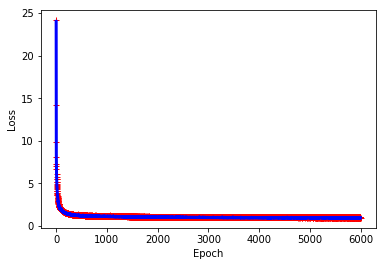

In [15]:
def train_polynomial_minibatch(*args, **kwargs):
    def polynomial_minibatch_gradient(batch_x, batch_y, theta):
        return np.dot(
                batch_x.T,
                np.dot(batch_x, theta) - np.reshape(batch_y, (-1, 1))
            )
    
    return minibatch(
        polynomial_minibatch_gradient,
        *args,
        **kwargs
    )

poly_gd_theta, poly_gd_data = train_polynomial_minibatch(
    lr=0.000075, epochs=6000
)
pretty_print("Polynomial, Minibatch GD", poly_gd_theta)
minibatch_plot(poly_gd_data)

## Ridge Regression &lt;Minibatch GD&gt; (Prob 6)


### Gradient Function


$$\nabla_\theta J(\theta) = X^T(X\theta - y) + \alpha \theta_R$$

In [0]:
def ridge_minibatch_gradient_alpha(alpha):
    def ridge_minibatch_gradient(batch_x, batch_y, theta):
        zero_ones = np.asarray([0] + [1] * (batch_x.shape[1] - 1))
        theta_r = zero_ones * theta.squeeze()
        theta_r = np.reshape(theta_r, (theta_r.shape[0], 1))

        return np.dot(
                batch_x.T,
                np.dot(batch_x, theta) - np.reshape(batch_y, (-1, 1))
            ) + alpha * theta_r
    
    return ridge_minibatch_gradient


### Adjusting hyperparameter $\alpha$

In [17]:
ridge_best_alpha = try_alpha_skl (
    regularization_type='l2',
    lr=0.000005, epochs=6000,
    iteration=5, set_iteration=6,
    max_depth=3, alpha_step=4
)

print("Best Alpha: %.4f" % ridge_best_alpha)


Examining Alpha for 0.0000, 0.1000
Alpha 0.0000 > Min Loss 1.2538, Avg Loss 1.3243, Score 1.3172
Alpha 0.0333 > Min Loss 1.2458, Avg Loss 1.3276, Score 1.3194
Alpha 0.0667 > Min Loss 1.2576, Avg Loss 1.3297, Score 1.3225
Alpha 0.1000 > Min Loss 1.2452, Avg Loss 1.3338, Score 1.3249

Examining Alpha for 0.0000, 0.0125
Alpha 0.0000 > Min Loss 1.2255, Avg Loss 1.3223, Score 1.3126
Alpha 0.0042 > Min Loss 1.2505, Avg Loss 1.3191, Score 1.3123
Alpha 0.0083 > Min Loss 1.2398, Avg Loss 1.3225, Score 1.3142
Alpha 0.0125 > Min Loss 1.2464, Avg Loss 1.3223, Score 1.3147

Examining Alpha for 0.0026, 0.0057
Alpha 0.0026 > Min Loss 1.2507, Avg Loss 1.3230, Score 1.3158
Alpha 0.0036 > Min Loss 1.2336, Avg Loss 1.3183, Score 1.3098
Alpha 0.0047 > Min Loss 1.2580, Avg Loss 1.3204, Score 1.3142
Alpha 0.0057 > Min Loss 1.2546, Avg Loss 1.3233, Score 1.3165

Best Alpha: 0.0036


### Fitting the model

Epoch:   0, Train Loss: 18.5065, Val Loss: 19.5165
Epoch: 300, Train Loss: 1.3163, Val Loss: 1.2732
Epoch: 600, Train Loss: 1.1994, Val Loss: 1.1612
Epoch: 900, Train Loss: 1.1046, Val Loss: 1.0684
Epoch: 1200, Train Loss: 1.0949, Val Loss: 1.0556
Epoch: 1500, Train Loss: 1.0692, Val Loss: 1.0300
Epoch: 1800, Train Loss: 1.0563, Val Loss: 1.0190
Epoch: 2100, Train Loss: 1.0453, Val Loss: 1.0046
Epoch: 2400, Train Loss: 1.0494, Val Loss: 1.0112
Epoch: 2700, Train Loss: 1.0240, Val Loss: 0.9809
Epoch: 3000, Train Loss: 1.0345, Val Loss: 0.9906
Epoch: 3300, Train Loss: 1.0393, Val Loss: 1.0032
Epoch: 3600, Train Loss: 1.0254, Val Loss: 0.9831
Epoch: 3900, Train Loss: 1.0166, Val Loss: 0.9788
Epoch: 4200, Train Loss: 1.0149, Val Loss: 0.9747
Epoch: 4500, Train Loss: 1.0176, Val Loss: 0.9753
Epoch: 4800, Train Loss: 1.0350, Val Loss: 0.9939
Epoch: 5100, Train Loss: 1.0098, Val Loss: 0.9672
Epoch: 5400, Train Loss: 1.0263, Val Loss: 0.9923
Epoch: 5700, Train Loss: 1.0135, Val Loss: 0.9691
==

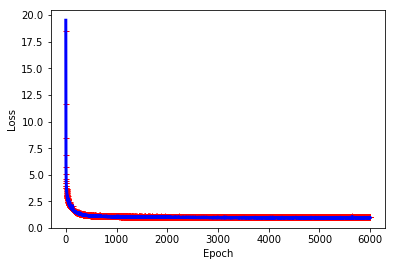

In [18]:
ridge_gd_theta, ridge_gd_data = minibatch (
    ridge_minibatch_gradient_alpha(ridge_best_alpha),
    lr=0.000075, epochs=6000
)

pretty_print("Ridge, Minibatch GD", ridge_gd_theta)
minibatch_plot(ridge_gd_data)

## Lasso Regression &lt;Minibatch GD&gt; (Prob 7)

### Gradient Function
$$\nabla_\theta J(\theta) = X^T (X\theta - y) + \alpha \theta_L$$
$$\theta_L = [0, sign(\theta_1), sign(\theta_2), ..., sign(\theta_{n-1})]^T$$

In [0]:
def lasso_minibatch_gradient_alpha(alpha):
    def lasso_minibatch_gradient(batch_x, batch_y, theta):
        theta_L = np.sign(theta)
        theta_L[0] = 0

        return np.dot(
                batch_x.T,
                np.dot(batch_x, theta) - np.reshape(batch_y, (-1, 1))
            ) + alpha * theta_L
    
    return lasso_minibatch_gradient


### Adjusting hyperparameter $\alpha$

In [20]:
lasso_best_alpha = try_alpha_skl (
    regularization_type='l1',
    lr=0.000005, epochs=6000,
    iteration=5, set_iteration=6, max_depth=3, alpha_step=4
)

print("Best Alpha: %.4f" % lasso_best_alpha)


Examining Alpha for 0.0000, 0.1000
Alpha 0.0000 > Min Loss 1.2410, Avg Loss 1.3197, Score 1.3118
Alpha 0.0333 > Min Loss 1.2617, Avg Loss 1.3468, Score 1.3383
Alpha 0.0667 > Min Loss 1.2839, Avg Loss 1.3590, Score 1.3515
Alpha 0.1000 > Min Loss 1.3014, Avg Loss 1.3721, Score 1.3650

Examining Alpha for 0.0000, 0.0125
Alpha 0.0000 > Min Loss 1.2641, Avg Loss 1.3206, Score 1.3149
Alpha 0.0042 > Min Loss 1.2438, Avg Loss 1.3230, Score 1.3150
Alpha 0.0083 > Min Loss 1.2526, Avg Loss 1.3264, Score 1.3190
Alpha 0.0125 > Min Loss 1.2622, Avg Loss 1.3258, Score 1.3195

Examining Alpha for 0.0000, 0.0016
Alpha 0.0000 > Min Loss 1.2532, Avg Loss 1.3252, Score 1.3180
Alpha 0.0005 > Min Loss 1.2441, Avg Loss 1.3216, Score 1.3138
Alpha 0.0010 > Min Loss 1.2531, Avg Loss 1.3167, Score 1.3104
Alpha 0.0016 > Min Loss 1.2675, Avg Loss 1.3243, Score 1.3187

Best Alpha: 0.0010


### Fitting the model

Epoch:   0, Train Loss: 22.4153, Val Loss: 21.3459
Epoch: 300, Train Loss: 1.3817, Val Loss: 1.3335
Epoch: 600, Train Loss: 1.2509, Val Loss: 1.2175
Epoch: 900, Train Loss: 1.2109, Val Loss: 1.1805
Epoch: 1200, Train Loss: 1.1692, Val Loss: 1.1329
Epoch: 1500, Train Loss: 1.1220, Val Loss: 1.0875
Epoch: 1800, Train Loss: 1.1019, Val Loss: 1.0629
Epoch: 2100, Train Loss: 1.0809, Val Loss: 1.0510
Epoch: 2400, Train Loss: 1.0671, Val Loss: 1.0291
Epoch: 2700, Train Loss: 1.0516, Val Loss: 1.0071
Epoch: 3000, Train Loss: 1.0446, Val Loss: 0.9997
Epoch: 3300, Train Loss: 1.0354, Val Loss: 1.0003
Epoch: 3600, Train Loss: 1.0455, Val Loss: 1.0022
Epoch: 3900, Train Loss: 1.0279, Val Loss: 0.9898
Epoch: 4200, Train Loss: 1.0217, Val Loss: 0.9837
Epoch: 4500, Train Loss: 1.0154, Val Loss: 0.9734
Epoch: 4800, Train Loss: 1.0197, Val Loss: 0.9731
Epoch: 5100, Train Loss: 1.0141, Val Loss: 0.9781
Epoch: 5400, Train Loss: 1.0235, Val Loss: 0.9784
Epoch: 5700, Train Loss: 1.0169, Val Loss: 0.9771
==

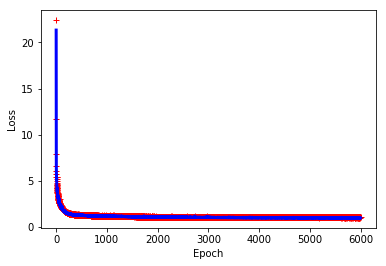

In [21]:
lasso_gd_theta, lasso_gd_data = minibatch (
    lasso_minibatch_gradient_alpha(lasso_best_alpha),
    lr=0.000075, epochs=6000
)

pretty_print("Lasso, Minibatch GD", lasso_gd_theta)
minibatch_plot(lasso_gd_data)